## 3D Gaussian Splatting for Real-Time Radiance Field Rendering

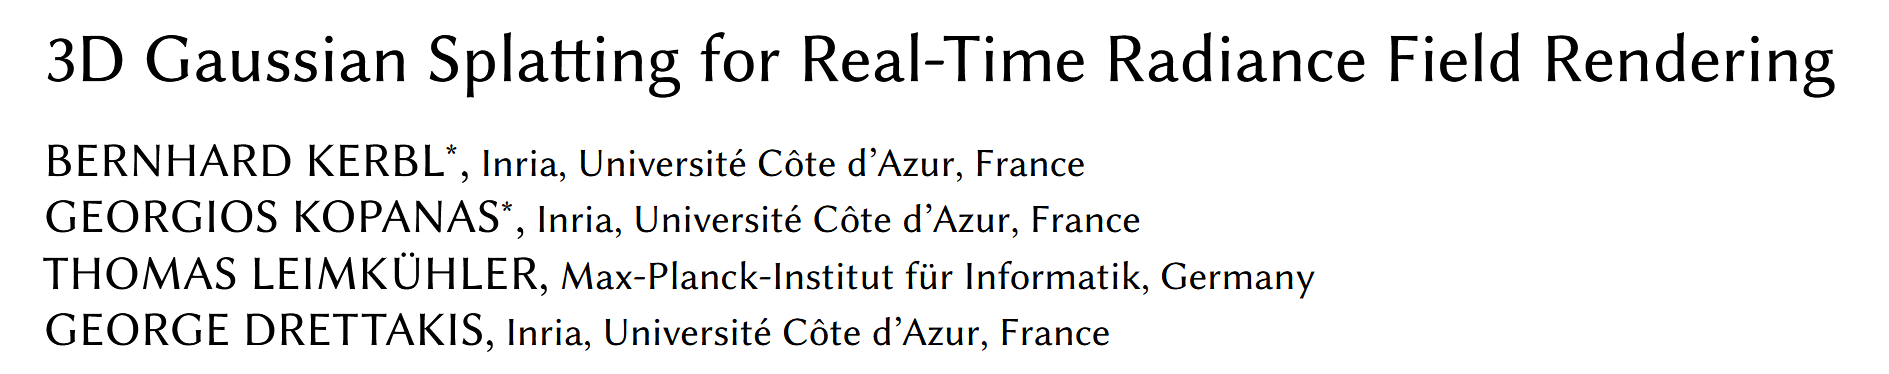
Code: https://github.com/graphdeco-inria/gaussian-splatting

## 1. Highlights

In computer graphics, traditional methods have limitations. NeRF, for example, offers **no direct visibility** into geometry, appearance, or structure—making it a "black box". It is also **slow and memory-intensive**.

3D Gaussian Splatting (3DGS) addresses these issues by **projecting 3D Gaussians onto 2D splats**, then **optimizing their parameters** to represent the scene. This approach enables **real-time rendering** with **high-quality results**.

## 2. Background

In recent years, Neural Radiance Fields (NeRFs) [Mildenhall et al. 2020] have emerged as a powerful representation for synthesizing novel views of a scene. NeRF models use **multi-layer perceptrons (MLPs)** and **volumetric ray marching**, allowing them to model fine geometry and view-dependent color. However, **NeRFs are notoriously slow** — rendering even a single image can take seconds, and training can take days.

Many methods have tried to accelerate NeRFs:

- **Mip-NeRF360** [Barron et al. 2022] achieves state-of-the-art quality but takes ~48 hours to train.
- **Plenoxels** [Fridovich-Keil et al. 2022] and **InstantNGP** [Müller et al. 2022] significantly reduce training time, but still struggle to render at real-time speeds for 1080p images.

These trade-offs raise a central question:  
> 💡 *Can we achieve both real-time rendering and high quality radiance field representation — without sacrificing speed or memory?*

This paper proposes a new paradigm: **3D Gaussian Splatting**.
which means gaussian can be splatted like snow ball from 3D space to 2D image.
Instead of voxel grids or MLPs, the authors represent scenes using a set of **anisotropic 3D Gaussians** in world space. These Gaussians can be:
- Projected to 2D splats for efficient rasterization,
- Differentiably optimized,
- Interleaved with **adaptive density control**, adding/removing Gaussians as needed.


## 3.The Core Idea

A **3D Gaussian** can be defined in Euclidean space by its center $\mu \in \mathbb{R}^3$ and covariance matrix $\Sigma \in \mathbb{R}^{3 \times 3}$:

$$
G(\mathbf{x}) = e^{ -\frac{1}{2} (\mathbf{x} - \mu)^T \Sigma^{-1} (\mathbf{x} - \mu) }
$$

This Gaussian defines a soft ellipsoidal shape, whose geometry is governed by $\Sigma$. Instead of optimizing $\Sigma$ directly, which may break symmetry or positive semi-definiteness, it is factored as:

$$
\Sigma = R S S^T R^T
$$

where $R$ is a rotation matrix (often represented via a quaternion) and $S$ is a diagonal scaling matrix. This ellipsoidal representation supports anisotropy and remains physically valid during optimization.

To **project** the 3D Gaussian onto the 2D image plane (i.e., rasterization), the covariance is transformed by the Jacobian $J$ of the camera projection and world-to-camera transformation $W$:

$$
\Sigma' = J W \Sigma W^T J^T
$$

This results in a 2D Gaussian splat, whose shape adapts to the viewing angle, allowing tile-based sorting and fast alpha blending.

The **appearance** of each point is encoded using **Spherical Harmonics (SH)** up to degree $L$. This allows compact modeling of view-dependent color:

$$
\mathbf{c}(\mathbf{v}) = \sum_{l=0}^{L} \sum_{m=-l}^{l} c_{lm} Y_{lm}(\mathbf{v})
$$

where $Y_{lm}$ are SH basis functions and $c_{lm}$ the learned coefficients per Gaussian.

For rendering, an alpha-blended formulation similar to volumetric raymarching is used:

$$
C = \sum_{i=1}^{N} T_i \alpha_i \mathbf{c}_i, \quad \text{with } \alpha_i = 1 - \exp(-\sigma_i \delta_i), \quad T_i = \prod_{j=1}^{i-1} (1 - \alpha_j)
$$

This equation is implemented efficiently by sorting Gaussians in tiles, blending front-to-back. Unlike NeRF, no ray marching is needed.

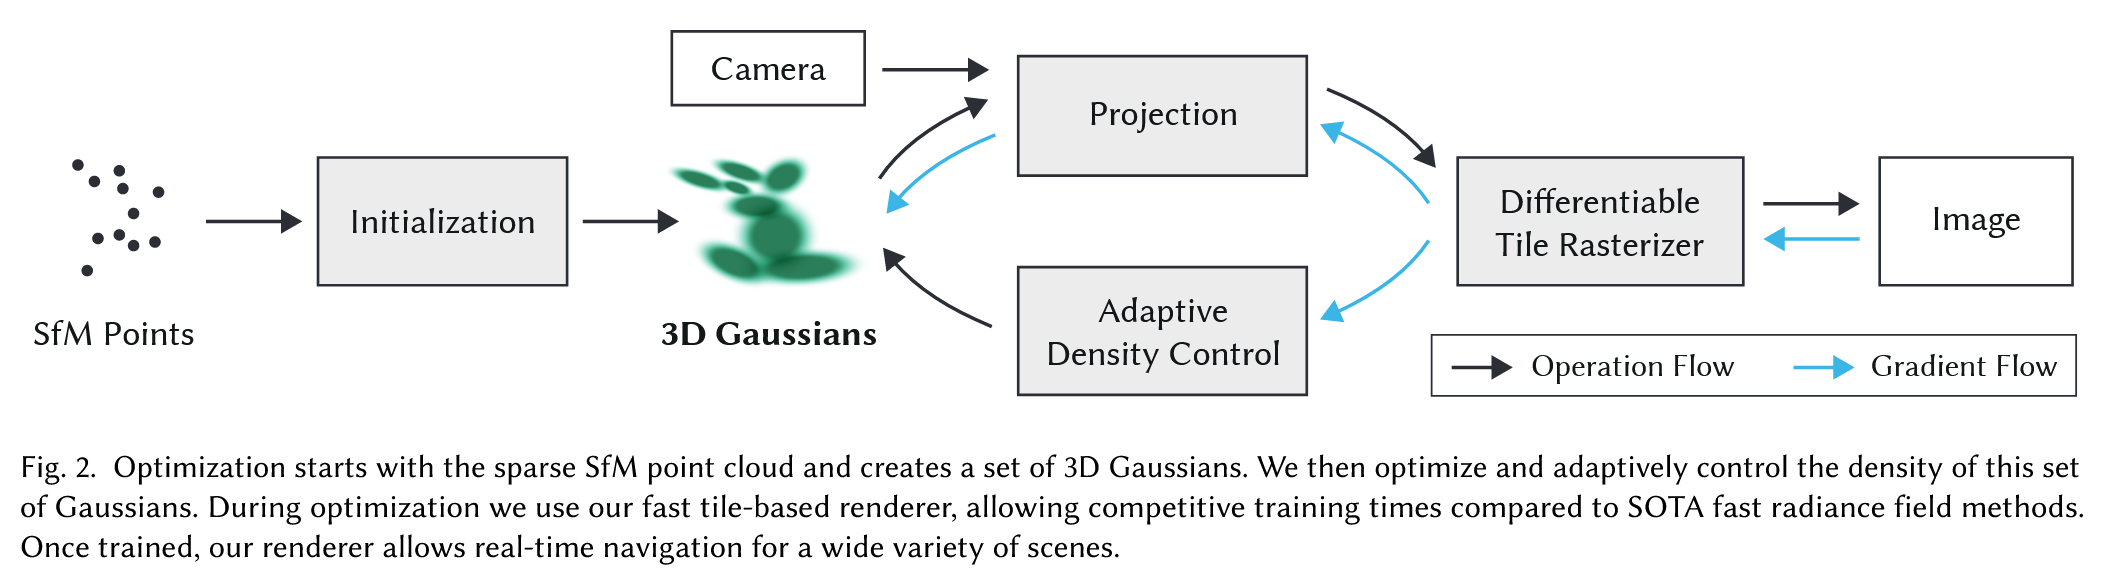
Optimization is performed on position $\mu$, rotation $R$, scale $S$, opacity $\alpha$, and SH coefficients $c_{lm}$. To avoid the overhead of autodiff on custom CUDA rasterizers, gradients are manually derived.

The pipeline begins with SfM points. Each is initialized as a Gaussian. During training, densification adds more Gaussians by cloning or splitting. Gaussians are pruned or merged using view-space statistics.

Antialiasing is inherently supported through the smooth falloff of each Gaussian splat in screen space. There is no hard surface discontinuity, and resolution-independence is naturally achieved through continuous alpha blending.

This model leads to a fast and differentiable pipeline for radiance field rendering, achieving real-time frame rates with state-of-the-art quality.



## References

- Mildenhall et al., NeRF: Representing Scenes as Neural Radiance Fields, ECCV 2020  
- Barron et al., Mip-NeRF360: Unbounded Anti-Aliased Neural Radiance Fields, CVPR 2022  
- Fridovich-Keil et al., Plenoxels: Radiance Fields without Neural Networks, CVPR 2022  
- Müller et al., InstantNGP: Instant Neural Graphics Primitives, SIGGRAPH 2022  
- Zwicker et al., EWA Volume Splatting, IEEE Vis 2001

### Start GUI for Real-Time Visualization

During training, a GUI server is used to visualize intermediate renderings. Start it with:

In [ ]:
python gui_server.py --ip 127.0.0.1 --port 6009

In [ ]:
import sys
import os

current_dir = os.path.dirname(os.path.abspath("__file__")) if "__file__" in locals() else os.getcwd()
gs_code_dir = os.path.abspath(os.path.join(current_dir, '../../../code/GS/gaussian-splatting-main'))
if gs_code_dir not in sys.path:
    sys.path.append(gs_code_dir)
print(f"✅ Added {gs_code_dir} to sys.path")

import torch
from random import randint
from utils.loss_utils import l1_loss, ssim
from gaussian_renderer import render, network_gui
import sys
from scene import Scene, GaussianModel
from utils.general_utils import safe_state, get_expon_lr_func
import uuid
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.image_utils import psnr
from argparse import ArgumentParser, Namespace
from arguments import ModelParams, PipelineParams, OptimizationParams
try:
    from torch.utils.tensorboard import SummaryWriter
    TENSORBOARD_FOUND = True
except ImportError:
    TENSORBOARD_FOUND = False

try:
    from fused_ssim import fused_ssim
    FUSED_SSIM_AVAILABLE = True
except:
    FUSED_SSIM_AVAILABLE = False

try:
    from diff_gaussian_rasterization import SparseGaussianAdam
    SPARSE_ADAM_AVAILABLE = True
except:
    SPARSE_ADAM_AVAILABLE = False
from train import prepare_output_and_logger,training_report

In [ ]:

from argparse import ArgumentParser

# 手动模拟命令行参数
sys.argv = ['']
# Set up command line argument parser
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--save_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--quiet", action="store_true")
parser.add_argument('--disable_viewer', action='store_true', default=False)
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=[])
parser.add_argument("--start_checkpoint", type=str, default = None)
args = parser.parse_args(sys.argv[1:])

args.save_iterations.append(args.iterations)

print("Optimizing " + args.model_path)

# Initialize system state (RNG)
safe_state(args.quiet)

# Start GUI server, configure and run training
if not args.disable_viewer:
    network_gui.init(args.ip, args.port)
torch.autograd.set_detect_anomaly(args.detect_anomaly)
# 参数对应展开（xxx = yyy 形式）
dataset = lp.extract(args)
opt = op.extract(args)
pipe = pp.extract(args)
testing_iterations = args.test_iterations
saving_iterations = args.save_iterations
checkpoint_iterations = args.checkpoint_iterations
checkpoint = args.start_checkpoint
debug_from = args.debug_from

In [ ]:
if not SPARSE_ADAM_AVAILABLE and opt.optimizer_type == "sparse_adam":
    sys.exit(f"Trying to use sparse adam but it is not installed, please install the correct rasterizer using pip install [3dgs_accel].")

first_iter = 0
tb_writer = prepare_output_and_logger(dataset)
gaussians = GaussianModel(dataset.sh_degree, opt.optimizer_type)
scene = Scene(dataset, gaussians)
gaussians.training_setup(opt)
if checkpoint:
    (model_params, first_iter) = torch.load(checkpoint)
    gaussians.restore(model_params, opt)

bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

iter_start = torch.cuda.Event(enable_timing = True)
iter_end = torch.cuda.Event(enable_timing = True)

use_sparse_adam = opt.optimizer_type == "sparse_adam" and SPARSE_ADAM_AVAILABLE 
depth_l1_weight = get_expon_lr_func(opt.depth_l1_weight_init, opt.depth_l1_weight_final, max_steps=opt.iterations)

viewpoint_stack = scene.getTrainCameras().copy()
viewpoint_indices = list(range(len(viewpoint_stack)))
ema_loss_for_log = 0.0
ema_Ll1depth_for_log = 0.0

progress_bar = tqdm(range(first_iter, opt.iterations), desc="Training progress")
first_iter += 1
for iteration in range(first_iter, opt.iterations + 1):
    if network_gui.conn == None:
        network_gui.try_connect()
    while network_gui.conn != None:
        try:
            net_image_bytes = None
            custom_cam, do_training, pipe.convert_SHs_python, pipe.compute_cov3D_python, keep_alive, scaling_modifer = network_gui.receive()
            if custom_cam != None:
                net_image = render(custom_cam, gaussians, pipe, background, scaling_modifier=scaling_modifer, use_trained_exp=dataset.train_test_exp, separate_sh=SPARSE_ADAM_AVAILABLE)["render"]
                net_image_bytes = memoryview((torch.clamp(net_image, min=0, max=1.0) * 255).byte().permute(1, 2, 0).contiguous().cpu().numpy())
            network_gui.send(net_image_bytes, dataset.source_path)
            if do_training and ((iteration < int(opt.iterations)) or not keep_alive):
                break
        except Exception as e:
            network_gui.conn = None

    iter_start.record()

    gaussians.update_learning_rate(iteration)

    # Every 1000 its we increase the levels of SH up to a maximum degree
    if iteration % 1000 == 0:
        gaussians.oneupSHdegree()

    # Pick a random Camera
    if not viewpoint_stack:
        viewpoint_stack = scene.getTrainCameras().copy()
        viewpoint_indices = list(range(len(viewpoint_stack)))
    rand_idx = randint(0, len(viewpoint_indices) - 1)
    viewpoint_cam = viewpoint_stack.pop(rand_idx)
    vind = viewpoint_indices.pop(rand_idx)

    # Render
    if (iteration - 1) == debug_from:
        pipe.debug = True

    bg = torch.rand((3), device="cuda") if opt.random_background else background

    render_pkg = render(viewpoint_cam, gaussians, pipe, bg, use_trained_exp=dataset.train_test_exp, separate_sh=SPARSE_ADAM_AVAILABLE)
    image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]

    if viewpoint_cam.alpha_mask is not None:
        alpha_mask = viewpoint_cam.alpha_mask.cuda()
        image *= alpha_mask

    # Loss
    gt_image = viewpoint_cam.original_image.cuda()
    Ll1 = l1_loss(image, gt_image)
    if FUSED_SSIM_AVAILABLE:
        ssim_value = fused_ssim(image.unsqueeze(0), gt_image.unsqueeze(0))
    else:
        ssim_value = ssim(image, gt_image)

    loss = (1.0 - opt.lambda_dssim) * Ll1 + opt.lambda_dssim * (1.0 - ssim_value)

    # Depth regularization
    Ll1depth_pure = 0.0
    if depth_l1_weight(iteration) > 0 and viewpoint_cam.depth_reliable:
        invDepth = render_pkg["depth"]
        mono_invdepth = viewpoint_cam.invdepthmap.cuda()
        depth_mask = viewpoint_cam.depth_mask.cuda()

        Ll1depth_pure = torch.abs((invDepth  - mono_invdepth) * depth_mask).mean()
        Ll1depth = depth_l1_weight(iteration) * Ll1depth_pure 
        loss += Ll1depth
        Ll1depth = Ll1depth.item()
    else:
        Ll1depth = 0

    loss.backward()

    iter_end.record()

    with torch.no_grad():
        # Progress bar
        ema_loss_for_log = 0.4 * loss.item() + 0.6 * ema_loss_for_log
        ema_Ll1depth_for_log = 0.4 * Ll1depth + 0.6 * ema_Ll1depth_for_log

        if iteration % 10 == 0:
            progress_bar.set_postfix({"Loss": f"{ema_loss_for_log:.{7}f}", "Depth Loss": f"{ema_Ll1depth_for_log:.{7}f}"})
            progress_bar.update(10)
        if iteration == opt.iterations:
            progress_bar.close()

        # Log and save
        training_report(tb_writer, iteration, Ll1, loss, l1_loss, iter_start.elapsed_time(iter_end), testing_iterations, scene, render, (pipe, background, 1., SPARSE_ADAM_AVAILABLE, None, dataset.train_test_exp), dataset.train_test_exp)
        if (iteration in saving_iterations):
            print("\n[ITER {}] Saving Gaussians".format(iteration))
            scene.save(iteration)

        # Densification
        if iteration < opt.densify_until_iter:
            # Keep track of max radii in image-space for pruning
            gaussians.max_radii2D[visibility_filter] = torch.max(gaussians.max_radii2D[visibility_filter], radii[visibility_filter])
            gaussians.add_densification_stats(viewspace_point_tensor, visibility_filter)

            if iteration > opt.densify_from_iter and iteration % opt.densification_interval == 0:
                size_threshold = 20 if iteration > opt.opacity_reset_interval else None
                gaussians.densify_and_prune(opt.densify_grad_threshold, 0.005, scene.cameras_extent, size_threshold, radii)
            
            if iteration % opt.opacity_reset_interval == 0 or (dataset.white_background and iteration == opt.densify_from_iter):
                gaussians.reset_opacity()

        # Optimizer step
        if iteration < opt.iterations:
            gaussians.exposure_optimizer.step()
            gaussians.exposure_optimizer.zero_grad(set_to_none = True)
            if use_sparse_adam:
                visible = radii > 0
                gaussians.optimizer.step(visible, radii.shape[0])
                gaussians.optimizer.zero_grad(set_to_none = True)
            else:
                gaussians.optimizer.step()
                gaussians.optimizer.zero_grad(set_to_none = True)

        if (iteration in checkpoint_iterations):
            print("\n[ITER {}] Saving Checkpoint".format(iteration))
            torch.save((gaussians.capture(), iteration), scene.model_path + "/chkpnt" + str(iteration) + ".pth")



### Key Design Concepts in the Code

This code implements **supervised**, **explicit**, and **differentiable** 3D Gaussian Splatting. Below are the highlights:

---

**1. Explicit Representation**

```python
gaussians = GaussianModel(dataset.sh_degree, opt.optimizer_type)
```

- Scene is modeled as a list of 3D Gaussians.
- Each has position, scale, rotation, color (SH), opacity.
- Unlike NeRF, this is fully **inspectable and editable**.

---

**2. Supervised Learning**

```python
gt_image = viewpoint_cam.original_image.cuda()
Ll1 = l1_loss(image, gt_image)
ssim_value = ssim(image, gt_image)
loss = (1.0 - opt.lambda_dssim) * Ll1 + opt.lambda_dssim * (1.0 - ssim_value)
```

- Uses ground truth RGB image.
- Supervised loss: L1 + SSIM.

---

**3. Differentiable Rasterization**
```python
rendered_image, radii, depth_image = rasterizer(...)
```

- Core rendering happens here using `GaussianRasterizer`.
- Each 3D Gaussian is:
  - Projected to 2D using camera matrices
  - Transformed to 2D ellipses using covariance
  - Blended into the final image using alpha compositing

```python
return _RasterizeGaussians.apply(...)
```

- This invokes a CUDA kernel that performs the splatting.
- It's **differentiable**, so gradients can flow through projection and blending.

> This rasterization is not neural — it's **analytical and explicit**, yet fully integrated into the training loop.

**4. Dynamic SH Complexity**

```python
if iteration % 1000 == 0:
    gaussians.oneupSHdegree()
```

- Increases SH degree during training.
- Allows progressive complexity in color modeling.

---
